<a href="https://colab.research.google.com/github/obeabi/Stocks_TSA/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install pandas_ta


In [26]:
import logging
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [27]:
# Importing the Keras libraries and packages
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2.15.0


## Fetch & Load the data

In [28]:
# Fetch historical stock data using yfinance
ticker = 'UPWK'
df = yf.download(ticker, start='2021-01-01', end='2024-01-03')

# Calculate technical indicators (RSI, MACD) using pandas_ta
df.ta.rsi(close="Close", append=True)
df.ta.macd(close="Close", append=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,
2021-01-04,35.110001,35.110001,33.349998,33.599998,33.599998,1436600,NaN,NaN,NaN,NaN
2021-01-05,33.150002,34.869999,33.110001,34.650002,34.650002,1190700,NaN,NaN,NaN,NaN
2021-01-06,34.680000,36.730000,34.230000,36.040001,36.040001,2179100,NaN,NaN,NaN,NaN
2021-01-07,37.259998,38.259998,35.540001,35.720001,35.720001,1605800,NaN,NaN,NaN,NaN
2021-01-08,36.099998,38.060001,35.759998,38.009998,38.009998,2378600,NaN,NaN,NaN,NaN


In [29]:
# Assuming df is your DataFrame with a 'Date' column

# Determine the split index based on the last two days
split_index = len(df) - 20

# Split the DataFrame into training and test sets
dataset_train = df.iloc[:split_index]
dataset_test  = df.iloc[split_index:]


dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,
2021-01-04,35.110001,35.110001,33.349998,33.599998,33.599998,1436600,NaN,NaN,NaN,NaN
2021-01-05,33.150002,34.869999,33.110001,34.650002,34.650002,1190700,NaN,NaN,NaN,NaN
2021-01-06,34.680000,36.730000,34.230000,36.040001,36.040001,2179100,NaN,NaN,NaN,NaN
2021-01-07,37.259998,38.259998,35.540001,35.720001,35.720001,1605800,NaN,NaN,NaN,NaN
2021-01-08,36.099998,38.060001,35.759998,38.009998,38.009998,2378600,NaN,NaN,NaN,NaN


In [30]:
# Specify the names of the two columns
column1 = 'Open'
column2 = 'Close'

# Create a new column with the average
#dataset_train['Open'] = dataset_train[[column1, column2]].mean(axis=1)
#dataset_test['Open'] = dataset_test[[column1, column2]].mean(axis=1)

# You can use 'Open' rather than 'Price'
features = ['Open','Close', 'Volume', 'RSI_14']
#features = ['Open', 'Close', 'Volume']
#features = ['Open','price', 'Close', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9']

dataset_train= dataset_train[features].copy()
dataset_test= dataset_test[features].copy()
no_indicators = len(features)


# Drop rows with missing data
dataset_train.dropna(inplace= True)
# Fill missing values in columns 'A' and 'B' using backfill
#columns_to_fill = features
#dataset_train[columns_to_fill] = dataset_train[columns_to_fill].fillna(method='bfill')


train_features = dataset_train.iloc[:, 0:].values


dataset_train.head()

,Open,Close,Volume,RSI_14
Date,,,,
2021-01-25,42.290001,44.119999,3262800,75.493248
2021-01-26,45.270000,45.230000,2565100,77.483002
2021-01-27,43.029999,42.980000,2359000,65.817602
2021-01-28,41.810001,42.599998,1325800,64.063359
2021-01-29,42.810001,41.450001,1371900,58.943255


### Feature Scaling

In [31]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_features)

print("The length of the sacled data is :" ,len(training_set_scaled) )
print()
training_set_scaled[0:5]

The length of the sacled data is : 720



array([[0.64435224, 0.68775892, 0.12955997, 0.89132226],
       [0.69812343, 0.70866288, 0.09695854, 0.92525152],
       [0.65770478, 0.66629   , 0.0873281 , 0.72633323],
       [0.63569111, 0.65913367, 0.03904976, 0.69641988],
       [0.65373514, 0.63747647, 0.04120387, 0.60911192]])

### Creating a data structure with 180 timesteps and 1 output

In [32]:
day_lag = 60
X_train = []
y_train = []
for i in range(day_lag, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-day_lag:i, 0:])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the dataset to add more indicators

In [33]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_indicators))

In [34]:
print("Shape of X_train after reshaping:", X_train.shape)

Shape of X_train after reshaping: (660, 60, 4)


## Part 2 - Building and Training the RNN

### Initialising the RNN

In [35]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [36]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], no_indicators)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [37]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [38]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [39]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [40]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [41]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [42]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
21/21 [==============================] - 25s 291ms/step - loss: 0.0249
Epoch 2/100
21/21 [==============================] - 5s 231ms/step - loss: 0.0078
Epoch 3/100
21/21 [==============================] - 6s 310ms/step - loss: 0.0057
Epoch 4/100
21/21 [==============================] - 5s 249ms/step - loss: 0.0049
Epoch 5/100
21/21 [==============================] - 2s 114ms/step - loss: 0.0053
Epoch 6/100
21/21 [==============================] - 3s 122ms/step - loss: 0.0048
Epoch 7/100
21/21 [==============================] - 4s 180ms/step - loss: 0.0060
Epoch 8/100
21/21 [==============================] - 2s 115ms/step - loss: 0.0041
Epoch 9/100
21/21 [==============================] - 2s 114ms/step - loss: 0.0059
Epoch 10/100
21/21 [==============================] - 3s 119ms/step - loss: 0.0042
Epoch 11/100
21/21 [==============================] - 2s 116ms/step - loss: 0.0043
Epoch 12/100
21/21 [==============================] - 4s 189ms/step - loss: 0.0038
Epoch 13/100

## Part 3 - Making the predictions and visualising the results

In [43]:
# Drop rows with missing data
#dataset_test[columns_to_fill] = dataset_test[columns_to_fill].fillna(method='bfill')
dataset_test.head()

,Open,Close,Volume,RSI_14
Date,,,,
2023-12-04,14.19,13.97,2855900,58.996555
2023-12-05,13.84,13.86,1560800,57.250568
2023-12-06,14.02,13.97,1495300,58.570963
2023-12-07,13.96,13.75,1056100,54.917561
2023-12-08,13.64,14.06,1160400,58.815809


In [44]:
# Plot a line chart using Plotly Express
fig = px.line(dataset_test, x=dataset_test.index, y='Open', title='Stock Price Over Time')

# Show the plot
fig.show()

In [45]:
# if Open price use this
real_stock_price = dataset_test.iloc[:, 0:1].values

# if Avergae price use this
#real_stock_price = dataset_test.iloc[:, -1:].values
real_stock_price[0:5]

array([[14.18999958],
       [13.84000015],
       [14.02000046],
       [13.96000004],
       [13.64000034]])

In [46]:
len(dataset_test)

20

### Getting the predicted stock price

In [47]:
# You can use 'Open'rather than 'Price'
dataset_total = pd.concat((dataset_train[features], dataset_test[features]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - day_lag : ].values
print("Shape of inputs before reshaping:", inputs.shape)
inputs = inputs.reshape(-1,no_indicators)
print("\nShape of inputs after reshaping:", inputs.shape)
inputs = sc.transform(inputs)

# Account for the 3D structure required by the LSTM
X_test = []
for i in range(day_lag, day_lag + len(dataset_test)):
    X_test.append(inputs[i-day_lag:i, 0:])


X_test = np.array(X_test)
print("Shape of X_test before reshaping:", X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_indicators))
print("\nShape of X_test after reshaping:", X_test.shape)
predicted_stock_price = regressor.predict(X_test)


# Concatenate each entry with zero individually
# Replace `x` with the desired number of zeros
num_zeros = no_indicators- 1
predicted_stock_price = np.array([np.concatenate((entry, np.zeros(num_zeros))) for entry in predicted_stock_price])



# Apply inverse_transform to concatenated_results
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Extract the first element from each entry (model predictions)
model_predictions = predicted_stock_price[:, 0]


Shape of inputs before reshaping: (80, 4)

Shape of inputs after reshaping: (80, 4)
Shape of X_test before reshaping: (20, 60, 4)

Shape of X_test after reshaping: (20, 60, 4)
1/1 [==============================] - 2s 2s/step


### Visualising the results

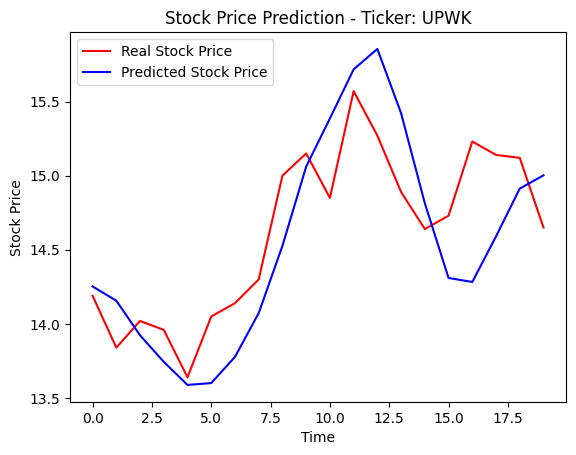

In [49]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(model_predictions , color = 'blue', label = 'Predicted Stock Price')
plt.title(f'Stock Price Prediction - Ticker: {ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()